<figure>
  <IMG src="figures/logo-esi-sba.png" WIDTH=300 height="100" ALIGN="right">
</figure>

# Practical Lab Series on Network Sciences   
*By Dr. Belkacem KHALDI (b.khaldi@esi-sba.dz)*

## Notebook 5: Introduction to Graph Attention Networks (GATs)
This Jupyter Notebook is designed to help you grasp the most  different aspects of  Graph Attention Networks (GAT) seen in the lecture.

##  Self-Attention in GATs
### Simple Example

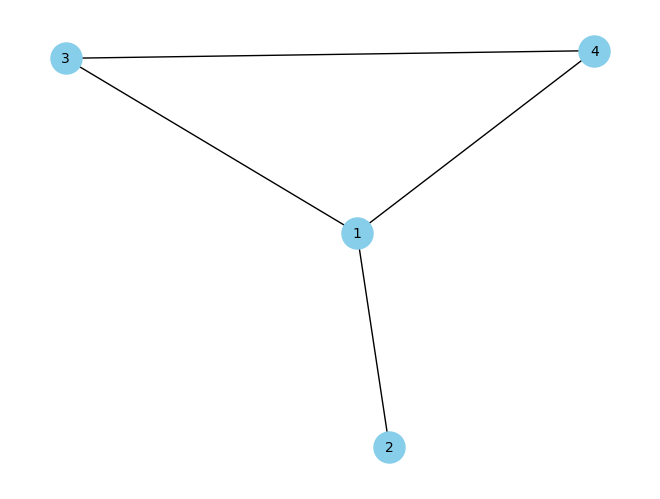

In [41]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Create an empty graph
G = nx.Graph()

# Add nodes
G.add_nodes_from([1, 2, 3, 4])

# Add edges
G.add_edge(1, 2)
G.add_edge(1, 3)
G.add_edge(1, 4)
G.add_edge(3, 4)

# Visualize the graph
pos = nx.spring_layout(G)  # Positioning of nodes
nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_color="black")
plt.show()

### Get the Adjacency Matrix

In [42]:
# Calculate the adjacency matrix A
adjacency_matrix = nx.adjacency_matrix(G).toarray()
print("Adjacency Matrix A:")
print(adjacency_matrix)

Adjacency Matrix A:
[[0 1 1 1]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 1 0]]


### Compute the attantion scores

In [43]:

class SelfAttentionGraph:
    def __init__(self, G, num_features):
        self.G = G
        self.num_nodes = len(G.nodes)
        self.num_features = num_features
        self.a_k = np.random.rand(num_features)  # Learnable weight vector for self-attention

    def calculate_self_attention(self, node_features):
        # get the adjacency matrix
        adjacency_matrix = nx.adjacency_matrix(self.G).toarray()

        # Calculate the attention scores for each node
        attention_scores = np.dot(node_features, self.a_k)

        # Apply the LeakyReLU activation function
        leaky_relu = lambda x: x if x > 0 else 0.2 * x
        leaky_relu_vec = np.vectorize(leaky_relu)
        activated_attention_scores = leaky_relu_vec(attention_scores)

        # Normalize the attention scores using the Softmax function
        attention_exp = np.exp(activated_attention_scores)
        attention_sum = np.sum(attention_exp)
        normalized_attention = attention_exp / attention_sum

        # Apply the adjacency matrix to the attention scores
        final_attention = np.dot(adjacency_matrix, normalized_attention)

        return final_attention

    def compute_final_features(self, node_features):
        final_attention = self.calculate_self_attention(node_features)

        # Compute the final representations of nodes
        output_features = np.dot(final_attention, node_features)
        return output_features



# Define node features (random values for simplicity)
num_features = 4
node_features = np.random.rand(len(G.nodes), num_features)

# Create a SelfAttentionGraph instance
self_attention_graph = SelfAttentionGraph(G, num_features= num_features)


# Calculate and print the final output features
output_features = self_attention_graph.compute_final_features(node_features)
print("Output Features:")
print(output_features)


Output Features:
[0.95427394 0.98486127 0.8654925  0.85929416]


## Challenge 1:
Use the karate_club_graph from NetworkX and Compute the Self-attention

- Use the following code for Help

```python
import networkx as nx
import matplotlib.pyplot as plt

# Load dataset
G = nx.karate_club_graph()

# Process labels (Mr. Hi = 0, Officer = 1)
labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

# Plot graph
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_color=labels,
                 node_size=800,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )
```

In [38]:
#Your Solution

## Install the required package

In [44]:
%pip install torch_geometric

## Import the necessary libraries
Downloading the Cora Dataset and Displaying Key Informations about it

In [45]:
# Import necessary libraries
from torch_geometric.datasets import Planetoid
# Download the Cora dataset using Planetoid
dataset = Planetoid(root=".", name="Cora")
# Access the dataset's data
data = dataset[0]

# Print general information about the dataset
print(f'Dataset: {dataset}')
print('---------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: Cora()
---------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7


### Visualizing Node Degrees

<BarContainer object of 37 artists>

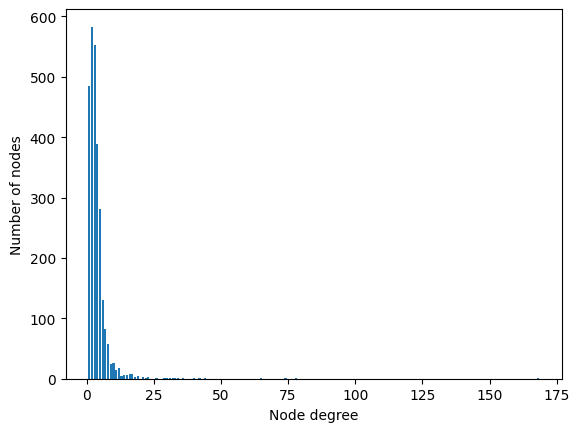

In [46]:

from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

## Implementing the GAT Class using the pre-built Using the Built-In implementation from `GATv2Conv` module of `torch_geometric.nn`

In [47]:
gat_train_losses, gat_val_losses =[], []
gat_train_accs, gat_val_accs =[], []

In [48]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GCNConv
from torch.nn import Linear, Dropout

def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)

    def forward(self, x, edge_index):
       # Apply dropout to the input features 'x'
       h = F.dropout(x, p=0.6, training=self.training)
       # Pass the input features through the first GAT layer ('gat1')
       h = self.gat1(h, edge_index)
       # Apply the Exponential Linear Unit (ELU) activation function
       h = F.elu(h)
       # Apply dropout to the features after the first GAT layer
       h = F.dropout(h, p=0.6, training=self.training)
       # Pass the features through the second GAT layer ('gat2')
       h = self.gat2(h, edge_index)
       # Apply the log softmax activation function to the final output features and return the result
       return F.log_softmax(h, dim=1)


    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=0.01)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')
                 # Append the values
                gat_train_losses.append(loss.item())
                gat_val_losses.append(val_loss.item())
                gat_train_accs.append(acc.item())
                gat_val_accs.append(val_acc.item())

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc



### Creating and Training the  Model

In [49]:
# Create the  model
gat = GAT(dataset.num_features, 32, dataset.num_classes)
print(gat)

# Train
gat.fit(data, epochs=100)

# Test
acc = gat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

GAT(
  (gat1): GATv2Conv(1433, 32, heads=8)
  (gat2): GATv2Conv(256, 7, heads=1)
)
Epoch   0 | Train Loss: 1.969 | Train Acc: 15.00% | Val Loss: 1.96 | Val Acc: 11.80%
Epoch  20 | Train Loss: 0.259 | Train Acc: 96.43% | Val Loss: 1.10 | Val Acc: 67.60%
Epoch  40 | Train Loss: 0.163 | Train Acc: 98.57% | Val Loss: 0.90 | Val Acc: 70.80%
Epoch  60 | Train Loss: 0.205 | Train Acc: 98.57% | Val Loss: 0.96 | Val Acc: 69.00%
Epoch  80 | Train Loss: 0.130 | Train Acc: 100.00% | Val Loss: 0.91 | Val Acc: 70.80%
Epoch 100 | Train Loss: 0.148 | Train Acc: 99.29% | Val Loss: 0.90 | Val Acc: 73.00%
GAT test accuracy: 82.00%


### Visualization

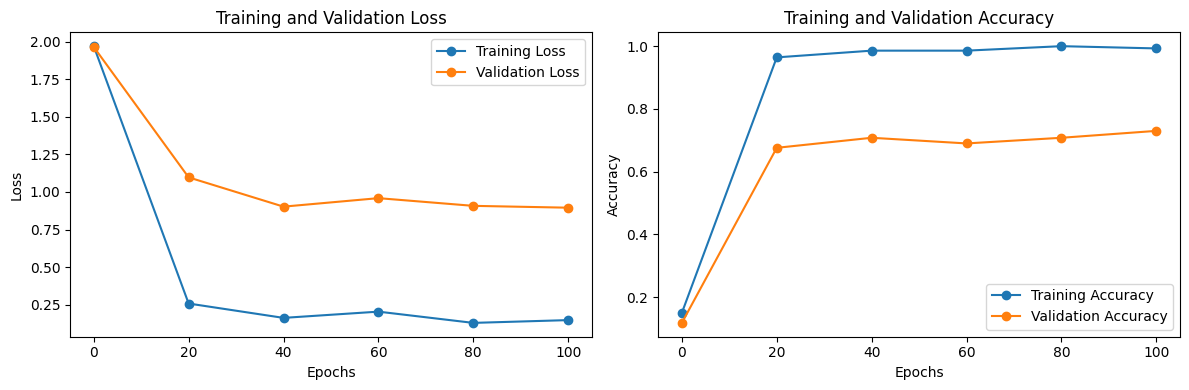

In [50]:

epochs = range(0, 101, 20)  # Assuming training every 20 epochs

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, gat_train_losses, label='Training Loss', marker='o')
plt.plot(epochs, gat_val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, gat_train_accs, label='Training Accuracy', marker='o')
plt.plot(epochs, gat_val_accs, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Challenge 2:

The Facebook Page-Page dataset This dataset was introduced by Rozemberczki et al. in 2019 [2]. In this dataset, each of the 22,470 nodes represents an official Facebook page.
Pages are connected when there are mutual likes between them. Node features (128-dim vectors) are created from textual descriptions written by the owners of these pages. Our goal is to classify each node into one of four categories: politicians, companies, television shows, and governmental organizations.

The Facebook Page-Page dataset is similar to the Cora dataset: it’s a social network with a node classification task. However, there are three major differences with Cora:
-  The number of nodes is much higher (2,708 versus 22,470)
-  The dimensionality of the node features decreased dramatically (from 1,433 to 128)
-  The goal is to classify each node into four categories instead of seven (which is easier since there are fewer options)

Following the previous steps in implementing the Built-In GCN model for the Cora dataset.
- Build a GCN model for the Facebook Page-Page dataset


`Hint:`

- Unlike Cora, Facebook Page-Page doesn’t have training, evaluation, and test masks by default. We can arbitrarily create masks with the range() function as follows:
```python
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)
```

- To import the FacebookPagePage Dataset you may use the following code:

```python
from torch_geometric.datasets import FacebookPagePage
```
- Then you can download it using this class:
```python
dataset = FacebookPagePage(root=".")
```

In [51]:
# Your Solution

## Challenge 3:
Create a DeepGAT class that updates the architecture of the GAT model (built-in)  to include 4 hidden layers while maintaining proper layer sizes, activation functions, and connectivity. See if the new Architecture provide better results for both the Cora and Facebook Datasets.

Here are some guidelines to help you achieve this:

- Create additional GCNConv layers to expand the depth of the model. You'll need to add two more layers to make a total of four hidden layers.

- Make sure each new GCNConv layer takes input from the previous layer and propagates it to the next layer. You should maintain the flow of information and keep it consistent with the original architecture.

- Ensure that the dimensions (number of output features) of the layers are suitable for your dataset and task. You might need to adjust these dimensions to achieve the desired performance.

- Use appropriate activation functions (e.g., ReLU) after each layer to introduce non-linearity into the model.

- Don't forget to update the forward method to include the new layers in the forward pass.



In [52]:
#Your Solution